In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from natsort import natsorted
import pickle


## Matplotlib global settings
plt.rcParams["axes.labelsize"] = 14
plt.rcParams["axes.labelweight"] = 10
plt.rcParams["axes.labelcolor"] = 'k'
plt.rcParams["axes.labelpad"] = 10
plt.rcParams["legend.fontsize"] = 10
plt.rcParams["xtick.labelsize"] = 12
plt.rcParams["ytick.labelsize"] = 12
plt.rcParams['xtick.color'] = 'dimgray'
plt.rcParams['ytick.color'] = 'dimgray'
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

In [2]:
def retrieveVariables(path,variables,parseKeyword = "top"):
    listOfFilesInPath = natsorted(os.listdir(path))
    justTimeSteps = [f for f in listOfFilesInPath if f.replace('.','',1).isdigit()][1:]  #Ignore zero time
    #justTimeSteps = [f for f in listOfFilesInPath if f.replace('.','',1).isdigit()]  #Include zero time
    
    time_float = [float(t) for t in justTimeSteps]
    results = pd.DataFrame({'Time (s)':np.array(time_float)})
    
    pickledFile = path + "/pickled.pkl"
    
    if os.path.exists(pickledFile):
        with open(pickledFile,'rb') as f:
            results = pickle.load(f)
    else:
        for variable in variables:
            ## Create a folder for the extracted variable
            folderForParsedTimesteps =  f"{path}/{variable}All"
            os.system(f"rm -rf {folderForParsedTimesteps}; mkdir {folderForParsedTimesteps}")

            varList = list()

            for time in justTimeSteps:
                fileToDump = f"{folderForParsedTimesteps}/{time}"
                grepParser = f'pcregrep -M -o3 "({parseKeyword})\n(^.*\n){{1,20}}[0-9]+\n[(]\n((-?[0-9]*[.].*\n)*)[)]" {path}/{time}/{variable} > {fileToDump}'
                os.system(grepParser)
                this = np.loadtxt(fileToDump)
                varList.append(this)

            results[f"{variable}"] = varList
        
        with open(pickledFile,'wb') as f:
            pickle.dump(results,f)

    return results

In [23]:
fields = ["DOC","NH4","NO3","O2","phi"]
RANS = retrieveVariables("./2.0NonZeroRANS/2.0NonZeroInitCondition/",fields)
LES  = retrieveVariables("./2.1LES/2.1NonZeroLESRun/",fields)
#RANS = retrieveVariables("./2.3ZeroStartRANS/2.3ZeroRANS/",fields)
#LES  = retrieveVariables("./2.2ZeroLES/2.2ZeroLESRun/",fields)

In [24]:
## Elliot-Brooks phi
hydCond = 1.3E-3
head_m  = 2.39E-4
bed_wavelenght = 0.15
depth_bed = 0.20
channel_width = 0.29
porosity = 0.33
settling_vel = 6.13E-6 ##From Jin2018
Axy = bed_wavelenght*channel_width

qBar = (2*hydCond * head_m / bed_wavelenght) * np.tanh(2*np.pi*depth_bed/bed_wavelenght)
print("qBar = {:.2E} m/s".format(qBar))

qBar += 0.5 * porosity * settling_vel
print("qBar = {:.2E} m/s".format(qBar))

qBar *= Axy
print("qBar = {:.2E} m3/s".format(qBar))

qBar = 4.14E-06 m/s
qBar = 5.15E-06 m/s
qBar = 2.24E-07 m3/s


In [25]:
## Negative phi is flux INTO the bed (influx)

for df in [RANS,LES]:
    df['Time (d)'] = df['Time (s)']/86400
    df['sumPhiIn (m3/s)']  = [ np.sum(np.minimum(p,0)) for p in df['phi'] ]
    df['sumPhiOut (m3/s)'] = [ np.sum(np.maximum(p,0)) for p in df['phi'] ]
    df['sumPhiNet (m3/s)'] = [ np.sum(p) for p in df['phi'] ]
    
    for field in fields: 
        df[f'massIn {field} (kg/s/m2)']  = [ np.sum(np.multiply(np.minimum(p,0),c))/Axy for p,c in zip(df['phi'],df[field]) ]
        df[f'massOut {field} (kg/s/m2)'] = [ np.sum(np.multiply(np.maximum(p,0),c))/Axy for p,c in zip(df['phi'],df[field]) ]
        df[f'massNet {field} (kg/s/m2)'] = [ np.sum(np.multiply(p,c))/Axy for p,c in zip(df['phi'],df[field]) ]

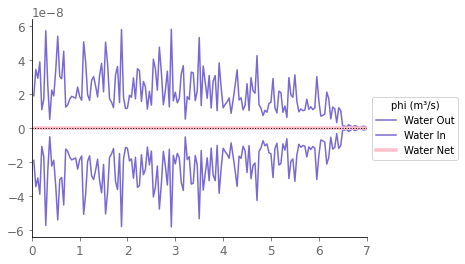

In [29]:
df = LES
fig,ax = plt.subplots(sharex=True,figsize=[6,4])
ax.plot(df['Time (d)'],df[f'sumPhiOut (m3/s)'],label='Water Out',
        c='slateblue',alpha=0.9,lw=1.5)
ax.plot(df['Time (d)'],df[f'sumPhiIn (m3/s)'],label='Water In',
        c='slateblue',alpha=0.9,lw=1.5)
ax.plot(df['Time (d)'],df[f'sumPhiNet (m3/s)'],label='Water Net',
        c='pink',alpha=1,lw=3.5)
ax.axhline(y=0,ls=':',lw=1,c='k')
ax.legend(loc='center left',bbox_to_anchor=(1.0,0.5),title=field+" (m³/s)")
ax.set(xlim=[0,7])
plt.show()

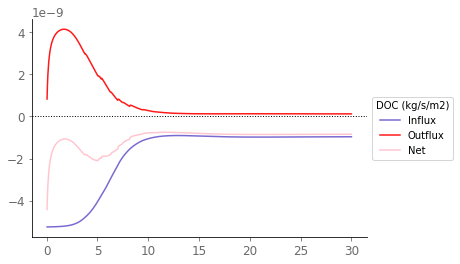

In [21]:
df,field = RANS,"DOC"
fig,ax = plt.subplots(sharex=True,figsize=[6,4])
ax.plot(df['Time (d)'],df[f'massIn {field} (kg/s/m2)'],label='Influx',
        c='slateblue',alpha=0.9,lw=1.5)
ax.plot(df['Time (d)'],df[f'massOut {field} (kg/s/m2)'],label='Outflux',
        c='red',alpha=0.9,lw=1.5)
ax.plot(df['Time (d)'],df[f'massNet {field} (kg/s/m2)'],label='Net',
        c='pink',alpha=0.9,lw=1.5)
ax.axhline(y=0,ls=':',lw=1,c='k')
ax.legend(loc='center left',bbox_to_anchor=(1.0,0.5),title=field+" (kg/s/m2)")
plt.show()

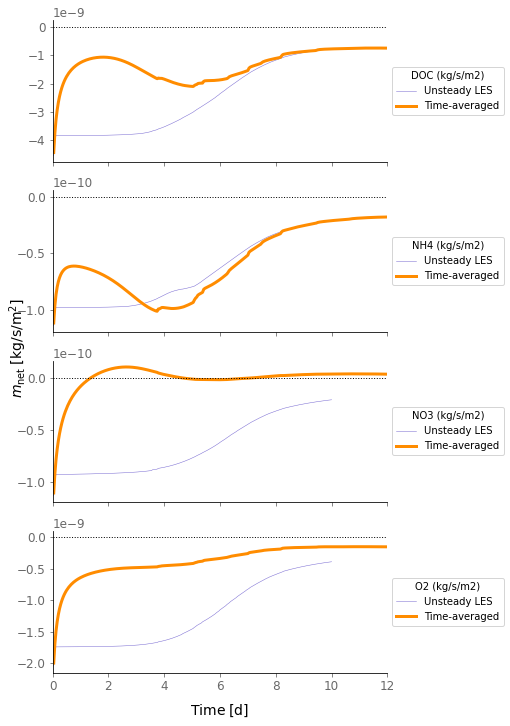

In [22]:
fig,axs = plt.subplots(4,1,sharex=True,figsize=[6,12])

for ax,field in zip(axs,fields):
    if "phi" in field:
        pass
    else:
        ax.plot(LES['Time (d)'],LES[f'massNet {field} (kg/s/m2)'],label='Unsteady LES',
                c='slateblue',alpha=0.9,lw=0.5)
        ax.plot(RANS['Time (d)'],RANS[f'massNet {field} (kg/s/m2)'],label='Time-averaged',
                c='darkorange',lw=3)
        ax.legend(loc='center left',bbox_to_anchor=(1.0,0.5),title=field+" (kg/s/m2)")
        ax.axhline(y=0,ls=':',lw=1,c='k')
ax.set(xlabel=r"$\mathsf{Time \; [d]}$",xlim=(0,12))
fig.supylabel(r"$m_\mathsf{net} \; \mathsf{[kg/s/m^2]}$",fontsize=14)
plt.show()